In [1]:
import tensorflow as tf
import os, shutil

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/kutaykutlu/forest-fire")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  kurniadiahmadwijaya


Your Kaggle Key:

  ································


  0%|                                                                                                          | 1.00M/2.46G [00:00<04:33, 9.69MB/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.46G/2.46G [01:19<00:00, 33.3MB/s]



Could not delete zip file, got [Errno 2] No such file or directory: './forest-fire/forest-fire.zip'


In [2]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## **Split Dataset Untuk Data Train Dan Test**

In [3]:
def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

copytree('forest-fire', 'data')

In [4]:
import os
import sys
import shutil

try:
    shutil.rmtree('data/test_big/')
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

try:
    shutil.rmtree('data/test_small/')
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

## **Split Folder Untuk Data Train**

In [5]:
import splitfolders

splitfolders.ratio('data', output="splitted_data", ratio=(0.8, 0.2))

Copying files: 13733 files [00:07, 1818.85 files/s]


## **Preprocessing Gambar Untuk Data Train**

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

training_set = train_datagen.flow_from_directory(
    'splitted_data/train/',
    target_size = (64,64),
    batch_size = 32,
    class_mode = 'binary'
)

Found 10985 images belonging to 2 classes.


In [7]:
training_set.class_indices

{'train-smoke': 0, 'train_fire': 1}

## **Preprocessing Gambar Untuk Data Test**

In [8]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory(
    'splitted_data/val/',
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'binary'
)

Found 2748 images belonging to 2 classes.


## **Membangun Model Convolutional Neural Network**


In [ ]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=7, activation='relu', input_shape=[64,64,3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

cnn.compile(
    optimizer = 'adam', 
    loss = 'binary_crossentropy', 
    metrics = ['accuracy']
)

In [10]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        4736      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 256)               1

## **Model Arsitektur CNN**

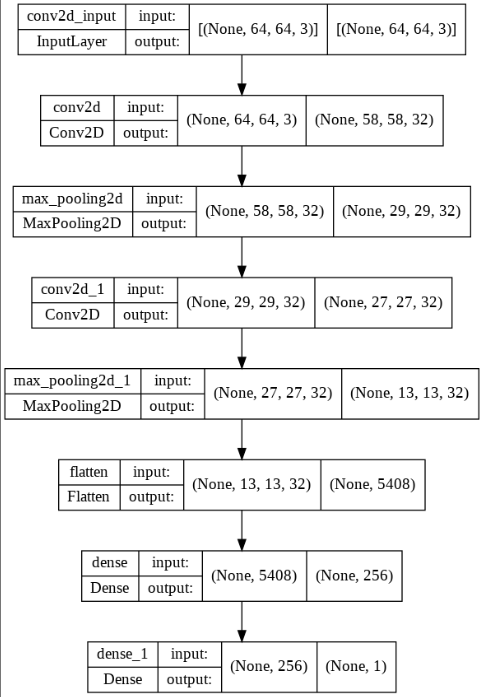

## **Melatih Model**

In [11]:
cnn.fit(x=training_set, epochs=5, validation_data=test_set)

Epoch 1/5


2022-03-15 20:30:37.705132: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301
2022-03-15 20:30:38.631897: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


344/344 [==============================] - 94s 266ms/step - loss: 0.0792 - accuracy: 0.9765 - val_loss: 0.0558 - val_accuracy: 0.9869
Epoch 2/5
344/344 [==============================] - 91s 263ms/step - loss: 0.0448 - accuracy: 0.9881 - val_loss: 0.0770 - val_accuracy: 0.9814
Epoch 3/5
344/344 [==============================] - 92s 268ms/step - loss: 0.0440 - accuracy: 0.9878 - val_loss: 0.0408 - val_accuracy: 0.9898
Epoch 4/5
344/344 [==============================] - 91s 264ms/step - loss: 0.0318 - accuracy: 0.9919 - val_loss: 0.0168 - val_accuracy: 0.9953
Epoch 5/5
344/344 [==============================] - 91s 265ms/step - loss: 0.0311 - accuracy: 0.9916 - val_loss: 0.0190 - val_accuracy: 0.9960


## **Evaluasi Model**

Hasil Prediksi  : Kebakaran (1)
Akurasi 	: 1.0 



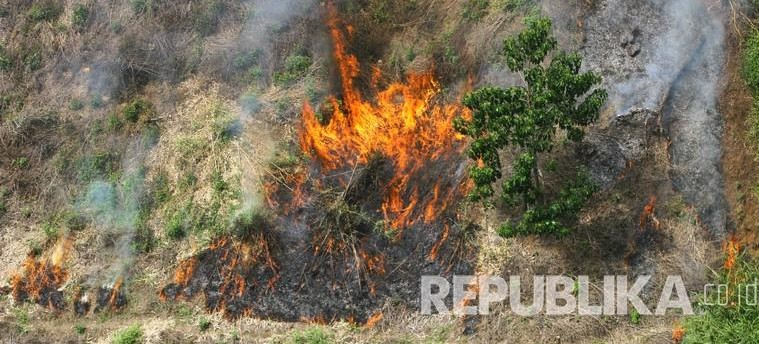

In [12]:
img = image.load_img('foto-udara-kebakaran-hutan-dan-lahan-di-pegunungan-meratus_200915144229-935.jpg')

predict = image.img_to_array(img) / 255
predict = tf.image.resize(predict, (64,64))
predict = tf.expand_dims(predict,axis=0)

prediction = cnn.predict(x=predict)[0][0]

if prediction > 0.8:
   print("Hasil Prediksi  : Kebakaran (1)")
else:
   print("Hasil Prediksi  : Tidak Kebakaran (0)") 

print("Akurasi \t:", cnn.predict(x=predict)[0][0], "\n")
img

Hasil Prediksi  : Tidak Kebakaran (0)
Akurasi 	: 0.19828472 



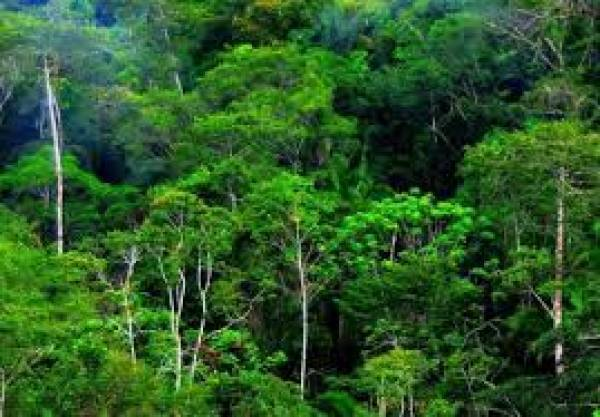

In [13]:
img = image.load_img('kenali-hutan-dan-fungsinya-76.jpg')

predict = image.img_to_array(img) / 255
predict = tf.image.resize(predict, (64,64))
predict = tf.expand_dims(predict,axis=0)

prediction = cnn.predict(x=predict)[0][0]

if prediction > 0.8:
   print("Hasil Prediksi  : Kebakaran (1)")
else:
   print("Hasil Prediksi  : Tidak Kebakaran (0)") 

print("Akurasi \t:", cnn.predict(x=predict)[0][0], "\n")
img